# Atividade — Segmentação Semântica (PyTorch) 🐾
**Objetivo:** treinar uma UNet no *Oxford‑IIIT Pet* (subset), avaliar (**IoU** e **Acurácia**), visualizar predições e exportar **FP32** para app Android

In [ ]:
#@title Instalar dependências extras (Colab)
!pip -q install torchmetrics==1.4.0.post0 matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
#@title Imports e configurações
import os, math, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
BATCH = 8
EPOCHS = 25
SUB_TRAIN = 200
SUB_VAL = 50

print("Torch:", torch.__version__, "| Torchvision:", torchvision.__version__, "| Device:", DEVICE)

Torch: 2.8.0+cu126 | Torchvision: 0.23.0+cu126 | Device: cpu


## Download dos dados

In [ ]:
#@title Baixar Oxford-IIIT Pet via torchvision.datasets (split 'trainval')
root = "/content/data"
os.makedirs(root, exist_ok=True)

# Pedimos o target_types="segmentation" para receber a máscara de segmentação
# A máscara do Oxford-IIIT Pet geralmente tem rótulos (1=pet, 2=border, 3=background).
trainval = OxfordIIITPet(
    root=root, split="trainval", target_types="segmentation",
    download=True
)
len(trainval)

100%|██████████| 792M/792M [00:21<00:00, 36.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.5MB/s]


3680

In [ ]:
import numpy as np
vals = {}
for i in range(20):
    _, mask_pil = trainval[i]  # direto do dataset original, target_types="segmentation"
    arr = np.array(mask_pil, dtype=np.uint8)
    u, c = np.unique(arr, return_counts=True)
    for k, v in zip(u, c):
        vals[k] = vals.get(k, 0) + v
print("Valores e contagens nas primeiras 20 máscaras:", vals)

Valores e contagens nas primeiras 20 máscaras: {np.uint8(1): np.int64(1409776), np.uint8(2): np.int64(3240415), np.uint8(3): np.int64(647543)}


## Preparo dos Dados

In [ ]:
#@title Transforms (imagem → tensor normalizado 0..1, máscara → binária 0/1)
to_tensor = transforms.ToTensor()
img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),  # 0..1
])

def mask_to_binary(mask_pil):
    m = np.array(mask_pil, dtype=np.uint8)
    m_bin = ((m == 1) | (m == 3)).astype(np.float32)  # pet OU borda = 1
    return torch.from_numpy(m_bin)[None, ...]

class PetSeg(torch.utils.data.Dataset):
    def __init__(self, base_ds):
        self.base = base_ds
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, mask = self.base[idx]
        img  = img_tf(img)
        # redimensiona máscara em modo nearest para não criar valores intermediários
        mask = transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.NEAREST)(mask)
        mask = mask_to_binary(mask)  # [1,H,W] float {0,1}
        return img, mask

# Subset reduzido p/ treino/val
idx = torch.randperm(len(trainval))
train_idx = idx[:SUB_TRAIN]
val_idx   = idx[SUB_TRAIN:SUB_TRAIN+SUB_VAL]

ds_train = PetSeg(Subset(trainval, train_idx))
ds_val   = PetSeg(Subset(trainval, val_idx))

dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

next(iter(dl_train))[0].shape, next(iter(dl_train))[1].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256]))

## Construção e Treinamento do Modelo

In [ ]:
#@title Definição de uma UNet compacta (PyTorch)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.c1 = DoubleConv(in_ch, base)
        self.p1 = nn.MaxPool2d(2)
        self.c2 = DoubleConv(base, base*2)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = DoubleConv(base*2, base*4)
        self.p3 = nn.MaxPool2d(2)
        self.c4 = DoubleConv(base*4, base*8)
        self.p4 = nn.MaxPool2d(2)

        self.bn = DoubleConv(base*8, base*16)

        self.u1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.c5 = DoubleConv(base*16 + base*8, base*8)
        self.u2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.c6 = DoubleConv(base*8 + base*4, base*4)
        self.u3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.c7 = DoubleConv(base*4 + base*2, base*2)
        self.u4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.c8 = DoubleConv(base*2 + base, base)

        self.out = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        c1 = self.c1(x); p1 = self.p1(c1)
        c2 = self.c2(p1); p2 = self.p2(c2)
        c3 = self.c3(p2); p3 = self.p3(c3)
        c4 = self.c4(p3); p4 = self.p4(c4)

        bn = self.bn(p4)

        u1 = self.u1(bn); u1 = torch.cat([u1, c4], dim=1); c5 = self.c5(u1)
        u2 = self.u2(c5); u2 = torch.cat([u2, c3], dim=1); c6 = self.c6(u2)
        u3 = self.u3(c6); u3 = torch.cat([u3, c2], dim=1); c7 = self.c7(u3)
        u4 = self.u4(c7); u4 = torch.cat([u4, c1], dim=1); c8 = self.c8(u4)

        return self.out(c8)  # logits [B,1,H,W]

model = UNetSmall().to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6

7.852545

In [ ]:
# utilitários para balanceamento e diretórios
import os, copy, json
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("export", exist_ok=True)

def estimate_pos_weight(dataloader, max_batches=20):
    """aproxima pos_weight = #neg / #pos em alguns batches do loader"""
    pos = 0; tot = 0
    for i, (_, m) in enumerate(dataloader):
        # m: [B,1,H,W] com {0,1}
        pos += m.sum().item()
        tot += m.numel()
        if i >= max_batches:
            break
    neg = tot - pos
    return max(neg / max(pos, 1), 1.0)

In [ ]:
#@title Laços de treino/val com métricas (IoU e Acurácia) + checkpoints
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# >>> pos_weight automático para lidar com desbalanceamento pet vs fundo
pos_w = torch.tensor([estimate_pos_weight(dl_train)], device=DEVICE)
print(f"pos_weight ~ {pos_w.item():.2f}")
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

# métricas
iou_metric = BinaryJaccardIndex().to(DEVICE)   # IoU
acc_metric = BinaryAccuracy().to(DEVICE)       # Accuracy

def step(dl, train=True, threshold=0.5):
    model.train(train)
    total_loss = 0.0
    iou_metric.reset(); acc_metric.reset()

    for imgs, masks in dl:
        imgs  = imgs.to(DEVICE, non_blocking=True)         # [B,3,H,W], float 0..1
        masks = masks.to(DEVICE, non_blocking=True)        # [B,1,H,W], float {0,1}

        logits = model(imgs)                               # [B,1,H,W], logits
        loss = criterion(logits, masks)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).to(torch.int)      # [B,1,H,W] int/bool
            iou_metric.update(preds, masks.to(torch.int))
            acc_metric.update(preds, masks.to(torch.int))

    n = len(dl.dataset)
    avg_loss = total_loss / n
    iou = iou_metric.compute().item()
    acc = acc_metric.compute().item()
    return avg_loss, iou, acc

# ----- treino + checkpoints -----
best_iou   = -1.0
best_epoch = -1
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS+1):
    train_loss, train_iou, train_acc = step(dl_train, train=True)
    val_loss,   val_iou,   val_acc   = step(dl_val,   train=False)

    history["train"].append((train_loss, train_iou, train_acc))
    history["val"].append((val_loss,   val_iou,   val_acc))

    # checkpoint desta época (com metadados)
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "val_iou": val_iou,
        "val_loss": val_loss
    }, f"checkpoints/ckpt_epoch_{epoch:02d}.pth")

    # melhor até agora (por IoU de validação)
    if val_iou > best_iou:
        best_iou   = val_iou
        best_epoch = epoch
        best_state = copy.deepcopy(model.state_dict())
        torch.save(best_state, "checkpoints/best_unet.pth")

    print(f"Epoch {epoch:02d} | "
          f"train: loss={train_loss:.4f}, IoU={train_iou:.3f}, Acc={train_acc:.3f} | "
          f"val: loss={val_loss:.4f}, IoU={val_iou:.3f}, Acc={val_acc:.3f} "
          f"(best IoU @ epoch {best_epoch}: {best_iou:.3f})")


pos_weight ~ 1.38
Epoch 01 | train: loss=0.7598, IoU=0.447, Acc=0.594 | val: loss=2.1293, IoU=0.028, Acc=0.556 (best IoU @ epoch 1: 0.028)
Epoch 02 | train: loss=0.6680, IoU=0.494, Acc=0.700 | val: loss=0.8013, IoU=0.524, Acc=0.662 (best IoU @ epoch 2: 0.524)
Epoch 03 | train: loss=0.6434, IoU=0.534, Acc=0.723 | val: loss=0.8186, IoU=0.505, Acc=0.665 (best IoU @ epoch 2: 0.524)
Epoch 04 | train: loss=0.6343, IoU=0.546, Acc=0.726 | val: loss=0.5922, IoU=0.583, Acc=0.758 (best IoU @ epoch 4: 0.583)
Epoch 05 | train: loss=0.6063, IoU=0.564, Acc=0.741 | val: loss=0.8576, IoU=0.387, Acc=0.703 (best IoU @ epoch 4: 0.583)
Epoch 06 | train: loss=0.6134, IoU=0.563, Acc=0.740 | val: loss=0.5633, IoU=0.589, Acc=0.755 (best IoU @ epoch 6: 0.589)
Epoch 07 | train: loss=0.5864, IoU=0.578, Acc=0.757 | val: loss=0.6814, IoU=0.521, Acc=0.713 (best IoU @ epoch 6: 0.589)
Epoch 08 | train: loss=0.5596, IoU=0.598, Acc=0.762 | val: loss=0.5535, IoU=0.588, Acc=0.758 (best IoU @ epoch 6: 0.589)
Epoch 09 | tra

## Visualização dos Resultados

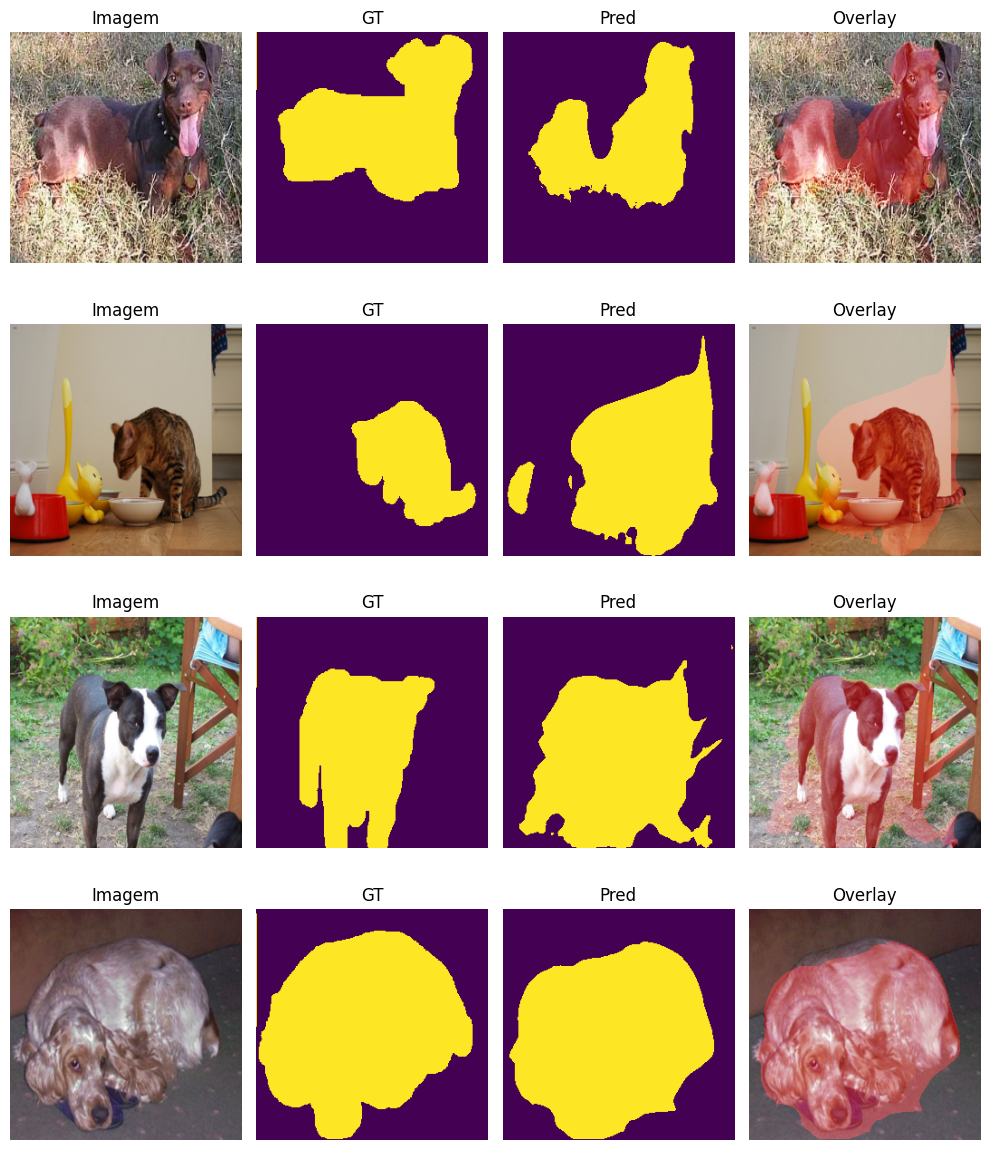

In [ ]:
#@title Mostrar grid: Imagem | GT | Predição | Overlay
import matplotlib.pyplot as plt, numpy as np
from torchvision.utils import make_grid

model.eval()
imgs, masks = next(iter(dl_val))
imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
with torch.no_grad():
    logits = model(imgs)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

def overlay(img_t, mask_t, alpha=0.5):
    # img_t: [3,H,W] 0..1 ; mask_t: [1,H,W] 0/1
    img = img_t.cpu().permute(1,2,0).numpy()
    m = mask_t.cpu().squeeze(0).numpy()
    ov = img.copy()
    # vermelho no canal R
    ov[...,0] = np.maximum(ov[...,0], m)  # reforça R onde mask==1
    return (alpha*ov + (1-alpha)*img)

n = min(4, imgs.size(0))
plt.figure(figsize=(10, n*3))
for i in range(n):
    img = imgs[i]
    gt  = masks[i]
    pr  = preds[i]
    ov  = overlay(img, pr)
    plt.subplot(n,4,4*i+1); plt.imshow(img.cpu().permute(1,2,0)); plt.axis('off'); plt.title("Imagem")
    plt.subplot(n,4,4*i+2); plt.imshow(gt.cpu().squeeze(0), vmin=0, vmax=1); plt.axis('off'); plt.title("GT")
    plt.subplot(n,4,4*i+3); plt.imshow(pr.cpu().squeeze(0), vmin=0, vmax=1); plt.axis('off'); plt.title("Pred")
    plt.subplot(n,4,4*i+4); plt.imshow(ov); plt.axis('off'); plt.title("Overlay")
plt.tight_layout(); plt.show()

## Exportação para Android (FP32 via TorchScript)

In [ ]:
# carrega e exporta o "best"
state = torch.load("checkpoints/best_unet.pth", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

example = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
traced  = torch.jit.trace(model, example).to("cpu")
ts_path = "export/unet_pet_fp32_torchscript.pt"
traced.save(ts_path)
print("TorchScript salvo em:", ts_path)

TorchScript salvo em: export/unet_pet_fp32_torchscript.pt


In [ ]:
#@title Baixar arquivo TorchScript
try:
    from google.colab import files
    files.download("export/unet_pet_fp32_torchscript.pt")
except Exception as e:
    print("Se estiver local, pegue o arquivo em /content/export/unet_pet_fp32_torchscript.pt", e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>